# Ansys solution example

This example shows how you can create a simple geometry directly using pansys, apply boundary conditions, loads, materials etc and run the solution.

In [1]:
from pansys import Ansys

In [2]:
ans = Ansys(startcommand='ansys150 -p ansys', cleanup=True)

In [3]:
ans.send('/prep7')

## Creating the FE model

In [4]:
ans.send('block,0,1,0,5,0,10,')

In [5]:
img = ans.plot('aplot')

In [6]:
from IPython.display import Image

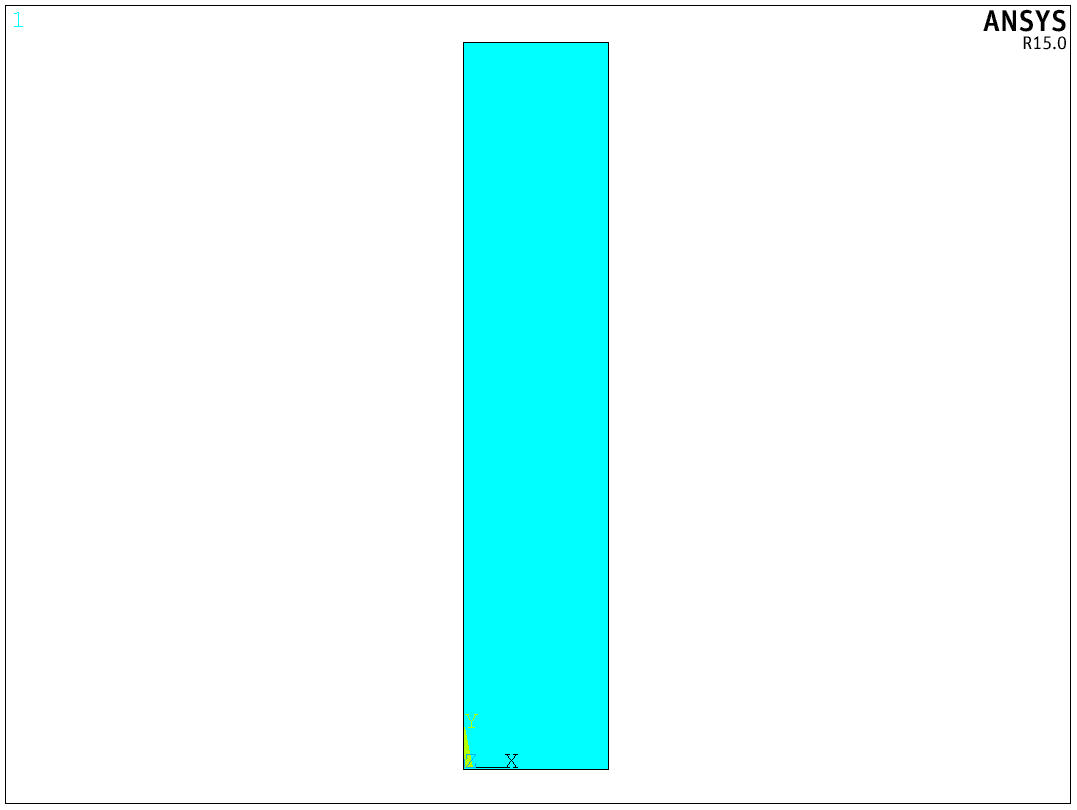

In [7]:
Image(img)

In [8]:
ans.send("et,1,SOLID185")

In [9]:
ans.send("vsweep, all")

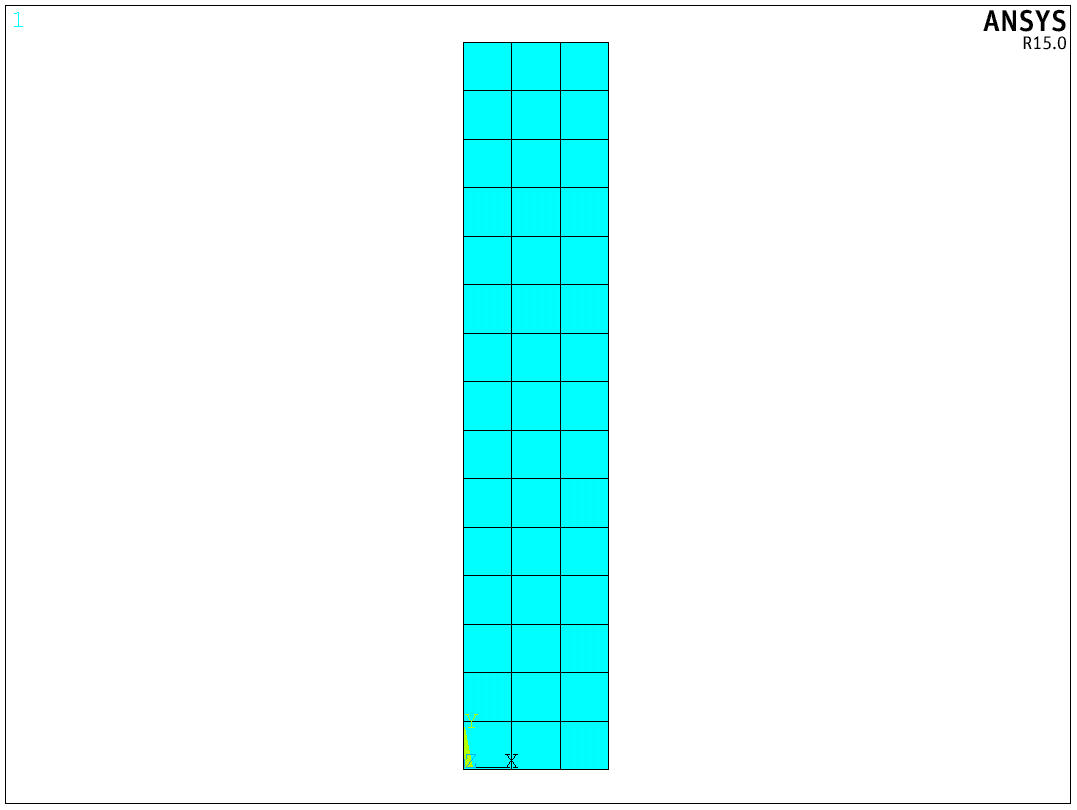

In [10]:
Image(ans.plot('eplot'))

## Creating components boundary conditions and loads

In [11]:
ans.send('nsel,r,loc,z,-0.01,0.01')

In [12]:
ans.send('cm,fixity,node')

In [13]:
ans.send('nsel,s,loc,z,10-0.01,10+0.01')

In [14]:
ans.send('cm,load,node')

## Applying loads and boundary conditions

In [15]:
nnodes = ans.get('node','','count')

In [16]:
nnodes

64

In [17]:
load_val = 1000

In [18]:
ans.send("""
finish
/solu
""")

In [19]:
ans.send("""
cmsel,s,fixity
d,all,all
""")

In [20]:
ans.send("""
cmsel,s,load
f,all,fx,{}
""".format(load_val/nnodes))

In [21]:
ans.send("allsel")

In [22]:
ans.send("""
/view,1,1,1,1
/ang,1
/auto,1
""")

In [23]:
ans.send('/pbc,all,,1')

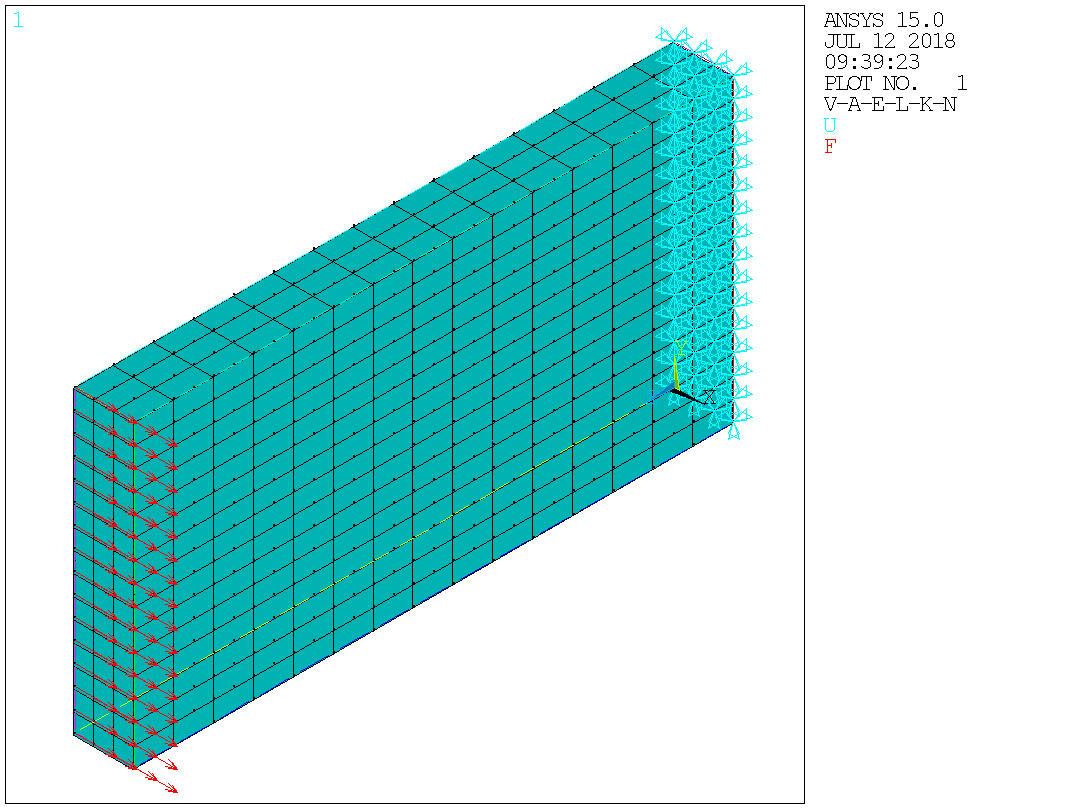

In [24]:
Image(ans.plot('gplot'))

## Applying material properties

In [25]:
ans.send('mp,ex,1,1e11')

In [26]:
ans.send('mp,mu,1,0.3')

## Start solution

After issueing the solve command, Ansys may show some warnings and ask whether it you want to proceed or not. pansys always asks ansys to proceed. The assumption here is that pansys is not really a replacement for interactive ANSYS, instead its a means to perform complicated automations with ANSYS. Hence, the user already know what she/he is going to do.

Setting the ``silent`` key of ``send`` command to ``False`` will make pansys show the output of the command in real time. If you want to process the output yourselves, you can pass a function to ``send`` command with ``output_func`` keyword argument.

In [27]:
ans.send('solve', silent=False)

solve

*****  ANSYS SOLVE    COMMAND  *****
*** NOTE ***                            CP =       0.838   TIME= 09:39:23
There is no title defined for this analysis.
*** SELECTION OF ELEMENT TECHNOLOGIES FOR APPLICABLE ELEMENTS ***
                ---GIVE SUGGESTIONS ONLY---

 ELEMENT TYPE    1 IS SOLID185. IT IS ASSOCIATED WITH LINEAR MATERIALS ONLY
 AND POISSON'S RATIO IS NOT GREATER THAN 0.49. KEYOPT(2)=3 IS SUGGESTED.



                       S O L U T I O N   O P T I O N S

   PROBLEM DIMENSIONALITY. . . . . . . . . . . . .3-D                  
   DEGREES OF FREEDOM. . . . . . UX   UY   UZ  
   ANALYSIS TYPE . . . . . . . . . . . . . . . . .STATIC (STEADY-STATE)
   GLOBALLY ASSEMBLED MATRIX . . . . . . . . . . .SYMMETRIC  

 *** WARNING ***                         CP =       0.844   TIME= 09:39:23
 Element 1 (SOLID185) uses material 1 for which Poisson's ratio is       
 undefined.  A default value of 0.3 will be used.  Input MP,PRXY, 1,0.3  
 to eliminate this warning.             

In [29]:
ans.send("""
finish
/post1""")

## Post processing

You can directly make plots from a Jupyter-notebook using the ``Image`` method of ``IPython.display`` module and ``plot`` method of ``Ansys`` object. 

Any plotting command passed to ``plot`` function will produce a new image file and return the path to that image file.

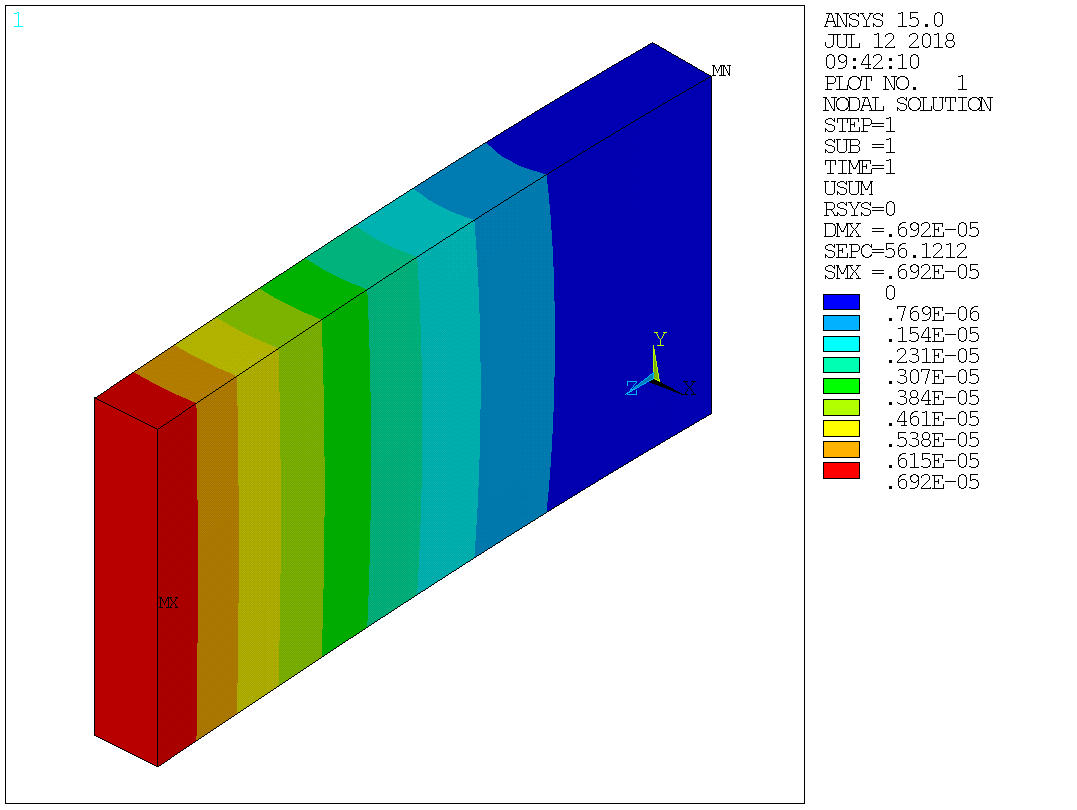

In [30]:
Image(ans.plot('plnsol,u,sum'))

### Extracting lists

Using the ``get_list`` method, you can extract any list which will return data in a column format. The function internally uses ``pandas.read_table`` and passes all keyword arguments from ``get_list`` to ``pandas.read_table``. Hence, you can use your own settings in case need arises.

In the following section, the displacement values from result is extracted and added it to the original coordinates of the nodes to get the updated positions. You can pass this back to the model to by writing out this dataframe and reading it back into model using ``nread`` command in ANSYS.

Extract displacements

In [31]:
disp = ans.get_list('prnsol,u,sum')

Setting node numbers as the index of the dataframe.

In [35]:
disp = disp.set_index('NODE')

In [41]:
disp.head()

,UX,UY,UZ,USUM
NODE,,,,
1,4.175461e-08,1.795474e-08,5.657464e-08,7.257073e-08
2,1.556826e-07,2.465593e-08,1.200923e-07,1.981594e-07
3,3.574027e-07,2.815715e-08,1.785558e-07,4.005142e-07
4,6.338732e-07,2.988743e-08,2.333957e-07,6.761376e-07
5,9.814102e-07,2.976412e-08,2.831793e-07,1.021882e-06


Getting the nodal locations

In [33]:
nlocs = ans.get_list('nlist')

In [38]:
nlocs = nlocs.set_index("NODE")

In [42]:
nlocs.head()

,X,Y,Z,THXY,THYZ,THZX
NODE,,,,,,
1,0.0,0.33333,0.66667,0.0,0.0,0.0
2,0.0,0.33333,1.33330,0.0,0.0,0.0
3,0.0,0.33333,2.00000,0.0,0.0,0.0
4,0.0,0.33333,2.66670,0.0,0.0,0.0
5,0.0,0.33333,3.33330,0.0,0.0,0.0


Creating a copy of nodal location dataframe and modifiying its X,Y and Z values to reflect the displacement results.

In [43]:
newloc = nlocs.copy()

In [47]:
newloc.X = newloc.X + disp.UX
newloc.Y = newloc.X + disp.UY
newloc.Z = newloc.X + disp.UZ

In [48]:
newloc.head()

,X,Y,Z,THXY,THYZ,THZX
NODE,,,,,,
1,1.670184e-07,1.849732e-07,2.235931e-07,0.0,0.0,0.0
2,6.227303e-07,6.473862e-07,7.428226e-07,0.0,0.0,0.0
3,1.429611e-06,1.457768e-06,1.608166e-06,0.0,0.0,0.0
4,2.535493e-06,2.565380e-06,2.768889e-06,0.0,0.0,0.0
5,3.925641e-06,3.955405e-06,4.208820e-06,0.0,0.0,0.0


### Extracting stress results

``prnsol,s,prin`` will output the principal stresses, stress intensity and equivalent stress as a column data. This when passed to ``get_list`` command will create a ``pandas`` DataFrame object which you can do operations on.

In [49]:
stress = ans.get_list('prnsol,s,prin')

In [57]:
stress_comp = ans.get_list('prnsol,s,comp')

In [51]:
stress.describe()

,NODE,S1,S2,S3,SINT,SEQV
count,1024.00000,1024.000000,1.024000e+03,1024.000000,1024.000000,1024.000000
mean,512.50000,1759.415595,3.906240e-10,-1759.415595,3518.831191,3373.138197
std,295.74764,2360.955818,4.121431e+02,2360.955818,2755.911176,2638.761378
min,1.00000,-67.431017,-1.516078e+03,-10182.646000,249.533180,232.421030
25%,256.75000,195.068432,-2.051532e+02,-2523.917175,1414.674325,1362.514750
50%,512.50000,555.387185,0.000000e+00,-555.387185,2718.112550,2668.931550
75%,768.25000,2523.917175,2.051532e+02,-195.068432,5313.088775,5205.215950
max,1024.00000,10182.646000,1.516078e+03,67.431017,10396.160000,9738.712700


In [58]:
stress_comp.describe()

,NODE,SX,SY,SZ,SXY,SYZ,SXZ
count,1024.00000,1.024000e+03,1.024000e+03,1.024000e+03,1.024000e+03,1.024000e+03,1024.000000
mean,512.50000,-9.768519e-12,-4.440892e-16,-1.012523e-13,-4.462516e-11,-9.960925e-10,261.900917
std,295.74764,3.877772e+02,4.235339e+02,4.016076e+03,7.717880e+01,2.005821e+02,643.002914
min,1.00000,-1.197029e+03,-1.516337e+03,-9.184036e+03,-5.706479e+02,-1.523964e+03,-766.467980
25%,256.75000,-9.239690e+01,-2.432290e+02,-2.510376e+03,-8.206400e+00,-5.648059e+01,48.175390
50%,512.50000,0.000000e+00,0.000000e+00,0.000000e+00,6.068757e-14,-5.000000e-09,112.944940
75%,768.25000,9.239690e+01,2.432290e+02,2.510376e+03,8.206400e+00,5.648059e+01,166.714970
max,1024.00000,1.197029e+03,1.516337e+03,9.184036e+03,5.706479e+02,1.523964e+03,3476.179700


In [56]:
stress[stress.SEQV == stress.SEQV.max()]

,NODE,S1,S2,S3,SINT,SEQV
443,444,157.91667,-1185.212,-10182.64600,10340.563,9738.7127
444,445,157.91667,-1185.212,-10182.64600,10340.563,9738.7127
486,487,10182.64600,1185.212,-157.91667,10340.563,9738.7127
487,488,10182.64600,1185.212,-157.91667,10340.563,9738.7127


### Plotting stress results

In [66]:
%matplotlib inline

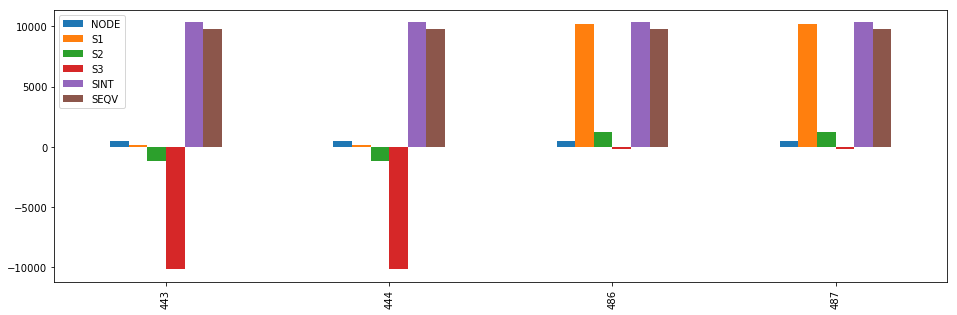

In [68]:
stress[stress.SEQV == stress.SEQV.max()].plot(kind='bar', figsize=(16,5))

### Finding the stress components of nodes with high equivalent stress

The following commands will extract all nodes where stress is equal to or greater than 95% of max equivalent stress and show their component stresses.

In [70]:
eqv_nodes = stress[stress.SEQV >= stress.SEQV.max()].NODE.values
stress_comp[stress_comp.NODE.apply(lambda x: x in eqv_nodes)]

,NODE,SX,SY,SZ,SXY,SYZ,SXZ
443,444,-1185.212,-1185.212,-8839.5173,-2.768785e-12,-29.764415,3476.1797
444,445,-1185.212,-1185.212,-8839.5173,3.013895e-12,29.764415,3476.1797
486,487,1185.212,1185.212,8839.5173,2.440367e-12,-29.764415,3476.1797
487,488,1185.212,1185.212,8839.5173,-2.427766e-12,29.764415,3476.1797


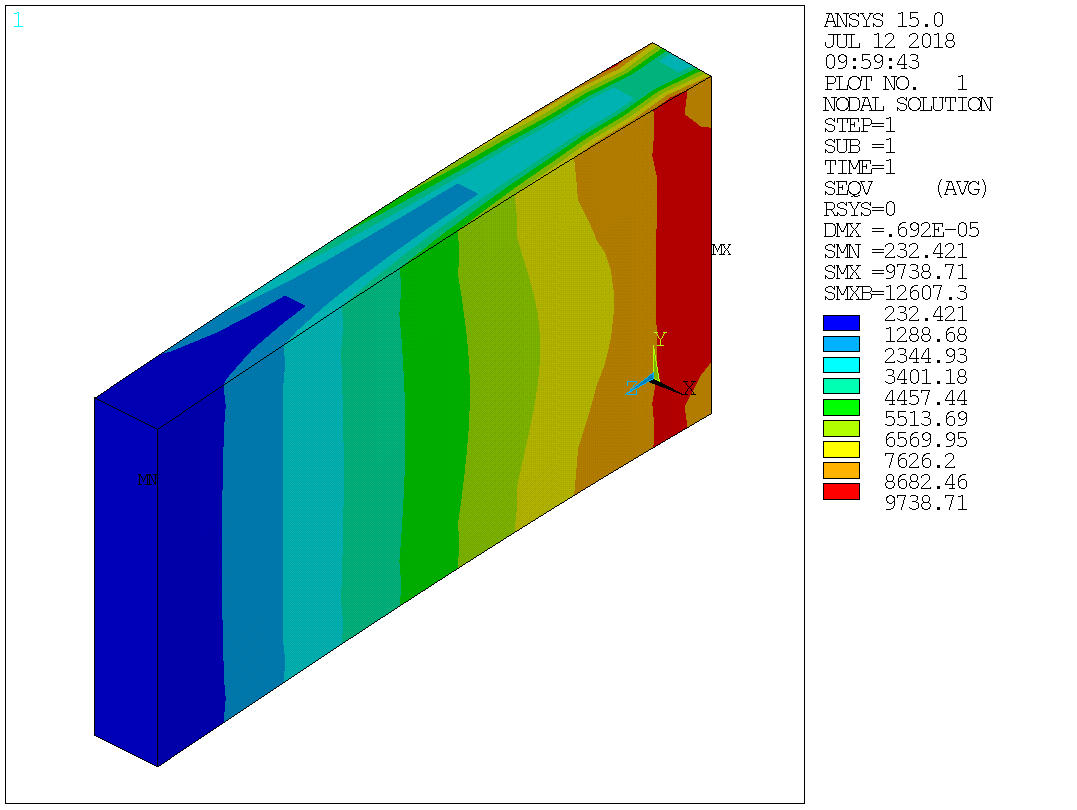

In [53]:
Image(ans.plot('plnsol,s,eqv'))